# Chapter11 심층 신경망 훈련하기

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf

- 심층 신경망 훈련 중에 일어날 문제들

 - 그레이디언트 소실/폭주

 - 훈련 데이터 부족 및 레이블을 만드는 작업 비용 부담

 - 급격히 줄어드는 훈련 속도

 - 훈련세트에 과대적합

### 11.1 그레이디언트 소실과 폭주 문제

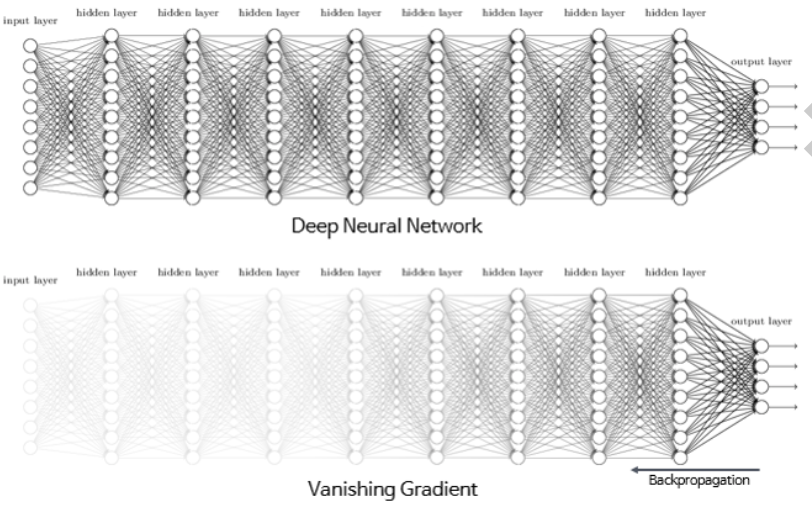

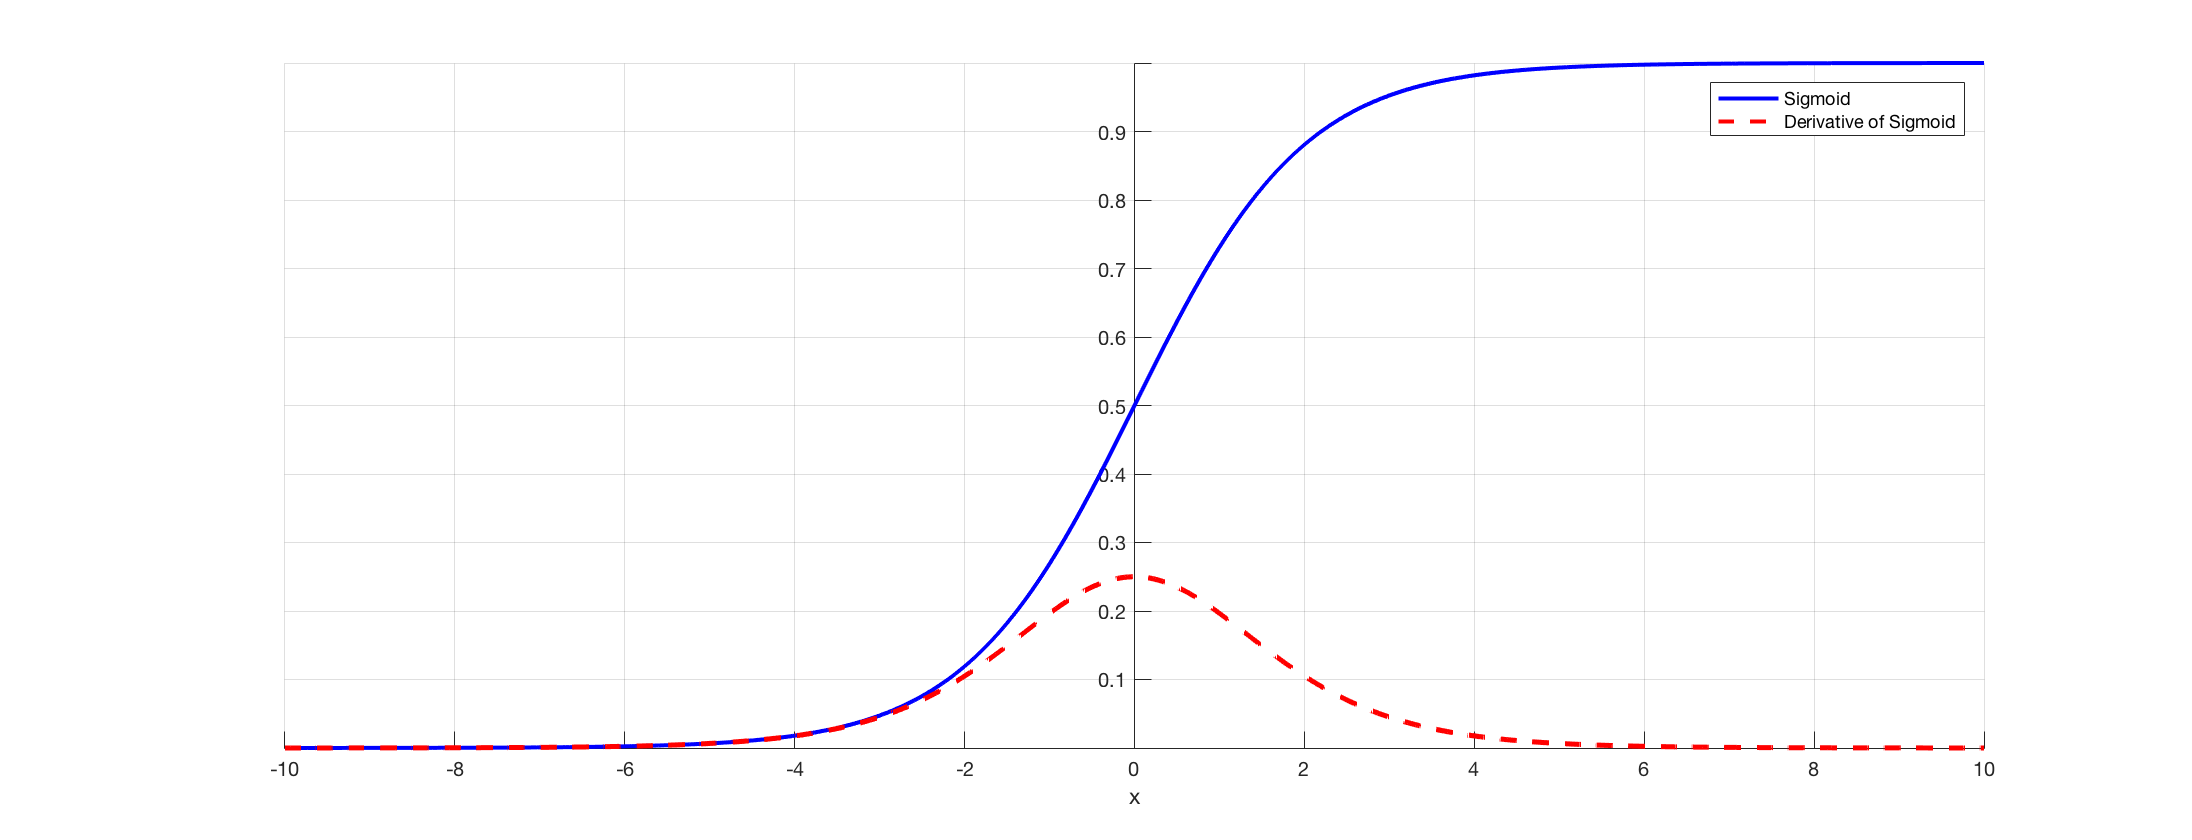

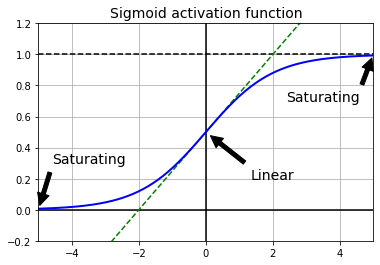

In [ ]:
def logit(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
plt.show()

- 그레이디언트 소실 :

 시그모이드의 최댓값이 0.25이므로 신경망이 깊어질수록 gradient가 0에 가까워진다 (기울기 소실)

- 그레이디언트 폭주 :

 기울기가 점차 커지더니 가중치들이 비정상적으로 큰 값이 되면서 결국 발산

1. 적절한 신호가 흐르기 위해서는 각 층의 출력에 대한 분산이 입력에 대한 분산과 같아야 한다.

2. 역방향에서 층을 통과하기 전과 후의 그레이디언트 분산이 동일해야 한다.

- Xavier 초깃값 (글로럿 초기화): 

 (S형 곡선의 활성화 함수)

 앞 계층의 노드가 n개라면, 표준편차가 $\frac{1}{\sqrt{n}}$ 인 분포 사용

- He 초깃값 :
 
 (ReLU 함수와 그 변종들)

 앞 계층의 노드가 n개일 때, 표준편차가 $\sqrt{\frac{2}{n}}$ 인 분포 사용

In [ ]:
# 케라스는 기본적으로 글로럿 초기화를 사용
keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal')   # 층을 만들 때 매개변수 변경

In [ ]:
he_avg_init = keras.initializers.VarianceScaling(scale=2, mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation='sigmoid', kernel_initializer=he_avg_init)

ReLU 함수 (Rectified Linear Unit) :

특정 양숫값에 수렴하지 않는다는 큰 장점이 있다 (계산도 빠름)

그러나, 훈련하는 동안 일부 뉴런이 0 이외의 값을 출력하지 않는다 (죽은 ReLU 문제)

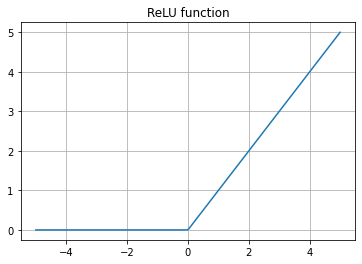

In [ ]:
# ReLU 함수
def ReLU(x):
    return np.maximum(x,0)

y = ReLU(z)
plt.plot(z,y)
plt.grid('on')
plt.title('ReLU function')
plt.show()

ReLU 함수의 변종 (수렴하지 않는 활성화 함수) :

- LeakyReLU : max($\alpha z, z$)

 하이퍼파라미터 $\alpha$ : '새는$^{leaky}$ 정도' 를 결정, LeakyReLU를 절대 죽지 않게 만들어준다.

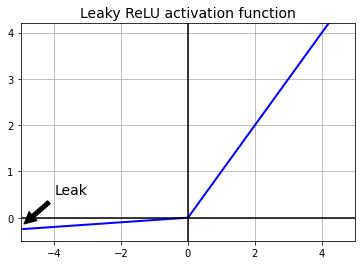

In [ ]:
# LeakyReLU 함수
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

- ELU (Exponential Linear Unit) 함수 :

 $ELU_\alpha (z) = \Bigg\{ 
\begin{align}
\alpha & (exp(z)-1) \;\; & z < 0\\
z & &z > 0\\
\end{align}$

 z < 0 일 때 음숫값이 들어오므로, 활성화 함수의 평균 출력이 0에 더 가까워진다. --> 그레이디언트 소실 문제 완화

 z < 0 이어도 죽은 뉴런을 만들지 않는다.

 z = 0 일 때도 미분 가능

그러나, ReLU나 그 변종들보다 계산이 느리다. (지수 함수 계산 때문)

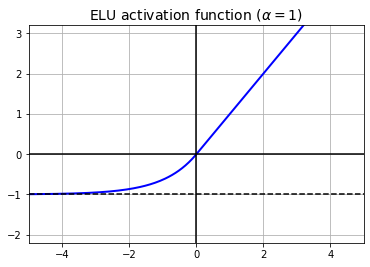

In [ ]:
# ELU 함수

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

[Self-Normalizing Neural Networks](https://pod3275.github.io/paper/2019/03/27/SELU.html)

- SeLU 활성화 함수

LeakyReLU를 사용해 패션 MNIST에서 신경망을 훈련해보자

In [ ]:
# 패션 MNIST 데이터셋 불러오기
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0   # 정규화
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]  # 테스트 세트 나누기
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),   # LeakyReLU 활성화함수
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
# 모델 컴파일
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# 모델 훈련
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7955 - accuracy: 0.7361 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7900
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8064
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5832 - accuracy: 0.8074 - val_loss: 0.5582 - val_accuracy: 0.8200
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5553 - accuracy: 0.8156 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5339 - accuracy: 0.8223 - val_loss: 0.5156 - val_accuracy:

- **배치 정규화** : 각 층에서 활성화 함수를 통과하기 전이나 후에 모델에 연산을 하나 추가하는 기법

 입력을 원점에 맞추고 정규화한 다음

 각 층에서 두 개의 새로운 파라미터로 결과값의 스케일을 조정하고 이동시킨다.

 1. 하난는 스케일 조정

 2. 다른 하나는 이동에 사용
 ---

1. $\mu_B = \frac{1}{m_B} \sum^{m_B}_{i=1}x^{(i)}\;$  --> 미니배치 $B$에 대해 평가한 입력의 평균 벡터

2. $\sigma_B^2 = \frac{1}{m_B} \sum^{m_B}_{i=1}\big(x^{(i)} - \mu_B \big)^2\;$ --> 미니배치에 대해 평가한 입력의 표준편차 벡터

3. $\hat{x}^{(i)} = \frac{x^{(i)} - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}\;$ --> 평균이 0이고 정규화된 샘플 $i$의 입력

4. $z^{(i)} = \gamma \otimes\! \, \hat{x}^{(i)} + \beta\;$ --> 배치 정규화 연산의 출력 (입력의 스케일을 조정하고 이동시킨 것)

 

In [ ]:
# 은닉층의 활성화 함수 후에 BatchNormalization 층을 추가
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='softmax')
])

층이 깊을수록 배치 정규화의 도움이 더 커진다!

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_5 (Dense)              (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_6 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

배치 정규화 층에서 네 개의 파라미터 $\gamma,\, \beta,\, \mu,\, \sigma$ 를 추가하는데, $\mu, \sigma$는 역전파로 학습되지 않기 때문에

Non-trainable params에 (3136 + 1200 + 400) / 2 = 2368 개가 있다.

In [ ]:
[(var.name, var.trainable) for var in  model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.8571 - accuracy: 0.7133 - val_loss: 0.5871 - val_accuracy: 0.8042
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6002 - accuracy: 0.7935 - val_loss: 0.5074 - val_accuracy: 0.8308
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5445 - accuracy: 0.8111 - val_loss: 0.4746 - val_accuracy: 0.8400
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5111 - accuracy: 0.8227 - val_loss: 0.4526 - val_accuracy: 0.8458
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4874 - accuracy: 0.8289 - val_loss: 0.4378 - val_accuracy: 0.8496
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4735 - accuracy: 0.8345 - val_loss: 0.4262 - val_accuracy: 0.8542
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4616 - accuracy: 0.8391 - val_loss: 0.4159 - val_accuracy

In [ ]:
# 배치 정규화 층을 활성화 함수 이전에 추가 (이 경우, 활성화 함수를 은닉층에서 지정하지 말고 배치 정규화 층 뒤에  별도의 층으로 추가)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),  # 배치 정규화 층에 입력마다 이동 파라미터를 포함하기 때문에 편향을 뺀다 (use_bias=False)
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

- 그레이디언트 클리핑

 역전파될 때 일정 임곗값을 넘어서지 못하게 그레이디언트를 잘라내는 것

 그레이디언트 폭주 문제를 완화

In [ ]:
# 케라스에서 그레이디언트 클리핑 구현
optimizer = keras.optimizers.SGD(clipvalue=1.0)  # 그레이디언트 벡터의 모든 원소를 -1.0과 1.0 사이로 클리핑한다
model.compile(loss='mse', optimizer=optimizer)

### 11.2 사전훈련된 층 재사용하기

- 전이 학습 : 해결하려는 것과 비슷한 유형의 문제를 처리한 신경망의 하위층을 재사용하는 것

 훈련 속도를 크게 높일 뿐만 아니라 필요한 훈련 데이터도 크게 줄여준다.

 일반적으로 원본 모델의 하위 은닉층이 상위 은닉층보다 더 유용하다.

 작업이 비슷할수록 더 많은 층을 재사용한다.
 

- 케라스를 사용한 전이학습

 - 모델A : 패션 MNIST 샌들과 셔츠를 제외한 8개 클래스를 분류하는 모델

 - 모델B : 샌들과 셔츠를 분류하는 이진분류기 (훈련샘플 200개)

 모델A로 모델B를 전이학습 시켜보자

In [ ]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # 샌들, 셔츠
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # 이진분류 (양성=셔츠, 음성=샌들)
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [ ]:
X_train_A.shape

(55000, 28, 28)

In [ ]:
X_train_B.shape

(200, 28, 28)

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# 모델A 만들기
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [ ]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.5927 - accuracy: 0.8104 - val_loss: 0.3896 - val_accuracy: 0.8667
Epoch 2/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.3523 - accuracy: 0.8786 - val_loss: 0.3289 - val_accuracy: 0.8824
Epoch 3/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3170 - accuracy: 0.8896 - val_loss: 0.3014 - val_accuracy: 0.8989
Epoch 4/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.2973 - accuracy: 0.8975 - val_loss: 0.2894 - val_accuracy: 0.9021
Epoch 5/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.2835 - accuracy: 0.9022 - val_loss: 0.2776 - val_accuracy: 0.9066
Epoch 6/20
1375/1375 [==============================] - 5s 3ms/step - loss: 0.2729 - accuracy: 0.9061 - val_loss: 0.2735 - val_accuracy: 0.9071
Epoch 7/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2641 - accuracy: 0.9093 - val_loss: 0.2720 - val_accuracy:

In [ ]:
# 모델A 저장
model_A.save("my_model_A.h5")

In [ ]:
# 모델B 만들기
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 1s 42ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 18ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 16ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 16ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 30ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 14ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 13ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [===========

In [ ]:
model_B.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_18 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_19 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_20 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_21 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                

In [ ]:
# 전이학습으로 모델B 만들기 (모델A로부터)
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
# model_B_on_A를 훈련하면 model_A도 영향을 받기 때문에 model_A 클론
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())    # 가중치 복사

In [ ]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 37ms/step - loss: 0.5728 - accuracy: 0.6550 - val_loss: 0.5777 - val_accuracy: 0.6389
Epoch 2/4
7/7 [==============================] - 0s 12ms/step - loss: 0.5370 - accuracy: 0.6850 - val_loss: 0.5409 - val_accuracy: 0.6836
Epoch 3/4
7/7 [==============================] - 0s 16ms/step - loss: 0.5008 - accuracy: 0.7300 - val_loss: 0.5094 - val_accuracy: 0.7130
Epoch 4/4
7/7 [==============================] - 0s 15ms/step - loss: 0.4699 - accuracy: 0.7500 - val_loss: 0.4812 - val_accuracy: 0.7343
Epoch 1/16


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


7/7 [==============================] - 1s 40ms/step - loss: 0.3926 - accuracy: 0.8200 - val_loss: 0.3436 - val_accuracy: 0.8661
Epoch 2/16
7/7 [==============================] - 0s 13ms/step - loss: 0.2780 - accuracy: 0.9350 - val_loss: 0.2591 - val_accuracy: 0.9280
Epoch 3/16
7/7 [==============================] - 0s 16ms/step - loss: 0.2073 - accuracy: 0.9650 - val_loss: 0.2103 - val_accuracy: 0.9554
Epoch 4/16
7/7 [==============================] - 0s 14ms/step - loss: 0.1664 - accuracy: 0.9800 - val_loss: 0.1787 - val_accuracy: 0.9686
Epoch 5/16
7/7 [==============================] - 0s 15ms/step - loss: 0.1394 - accuracy: 0.9800 - val_loss: 0.1559 - val_accuracy: 0.9767
Epoch 6/16
7/7 [==============================] - 0s 14ms/step - loss: 0.1196 - accuracy: 0.9950 - val_loss: 0.1392 - val_accuracy: 0.9797
Epoch 7/16
7/7 [==============================] - 0s 14ms/step - loss: 0.1050 - accuracy: 0.9950 - val_loss: 0.1266 - val_accuracy: 0.9838
Epoch 8/16
7/7 [======================

In [ ]:
# 그냥 만든 모델B의 점수
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.1408 - accuracy: 0.9705


[0.1408407837152481, 0.9704999923706055]

In [ ]:
# 모델A로부터 전이학습으로 만든 모델B의 점수
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0682 - accuracy: 0.9930


[0.06824079155921936, 0.9929999709129333]

### 11.3 고속 옵티마이저

- 모멘텀 최적화

 1. $m \leftarrow \beta m - \eta \nabla_\theta J(\theta)$

 2. $\theta \leftarrow \theta + m$

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


- 네스테로프 가속 경사 (모멘텀 최적화의 변종)

 1. $m \leftarrow \beta m - \eta \nabla_\theta J(\theta + \beta m)$

 2. $\theta \leftarrow \theta + m$

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


- AdaGrad

 1. $s \leftarrow s + \nabla_\theta J(\theta) \otimes\!\, \nabla_\theta J(\theta)$

 2. $\theta \leftarrow \theta - \eta \nabla_\theta J(\theta) \oslash\!\, \sqrt{s+\epsilon}$
 
 훈련하면서 학습률을 감소시키지만 경사가 완만한 차원보다 가파른 차원에 대해 더 빠르게 감소시킨다. (적응적 학습률)

 심층신경망에서는 사용 자제

In [ ]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


- RMSProp

 1. $s \leftarrow \beta s + (1 - \beta) \nabla_\theta J(\theta) \otimes\!\,\nabla_\theta J(\theta)$

 2. $\theta \leftarrow \theta - \eta \nabla_\theta J(\theta) \oslash \sqrt{s + \epsilon}$

 적응적 학습률을 적용하지만, 가장 최근의 그레이디언트만 누적 (오래된 기억은 삭제)

In [ ]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)  # rho는 beta에 해당

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


- Adam ( 모멘텀 최적화 + RMSProp ) - 적응적 모멘트 추정

 1. $m \leftarrow \beta_1 m - (1-\beta_1)\nabla_\theta J(\theta)$

 2. $s \leftarrow \beta_2 s + (1-\beta_2)\nabla_\theta J(\theta) \otimes\!\,\nabla_\theta J(\theta)$ 

 3. $\hat{m} \leftarrow \frac{m}{1-\beta_1^t}$
 
 4. $\hat{s} \leftarrow \frac{s}{1-\beta_2^t}$

 5. $\theta \leftarrow \theta + \eta\,\hat{m} \oslash\!\, \sqrt{\hat{s}+\epsilon}$

In [ ]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Adam의 변종

- Adamax

- Nadam

- 학습률 스케줄링 :

 큰 학습률로 시작하고 학습 속도가 느려질 때 학습률을 낮추면 최적의 고정 학습률보다 은 솔루션을 더 빨리 발견할 수 있다.

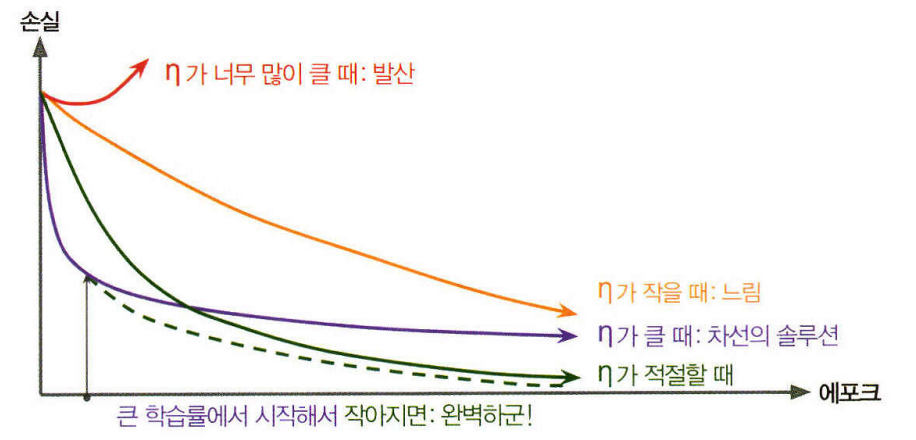

In [ ]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [ ]:
# 케라스에서 거듭제곱 기반 스케줄링 구현
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# 지수 기반 스케줄링
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch/20)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [ ]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)  # 지수 기반 스케줄링을 전달하여 LearningRateSchedular 콜백 생성
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 11s 6ms/step - loss: 0.8905 - accuracy: 0.7447 - val_loss: 1.0356 - val_accuracy: 0.7082
Epoch 2/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.7753 - accuracy: 0.7700 - val_loss: 0.6706 - val_accuracy: 0.8220
Epoch 3/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5851 - accuracy: 0.8221 - val_loss: 0.6445 - val_accuracy: 0.8190
Epoch 4/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5490 - accuracy: 0.8295 - val_loss: 0.4693 - val_accuracy: 0.8502
Epoch 5/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4706 - accuracy: 0.8501 - val_loss: 0.4505 - val_accuracy: 0.8630
Epoch 6/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4423 - accuracy: 0.8590 - val_loss: 0.4871 - val_accuracy: 0.8440
Epoch 7/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4067 - accuracy: 0.8673 - val_loss: 0.4751 - val_ac

In [ ]:
# 케라스로 지수 기반 스케줄링 구현 -> 앞에서의 exponential_decat_fn()과 동일
s = 20 * len(X_train) // 32
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)

### 11.4 규제를 사용해 과대적합 피하기

- $l_1$과 $l_2$ 규제

In [ ]:
layer = keras.layers.Dense(100, activation='elu',
                           kernel_initializer='he_normal',
                           kernel_regularizer=keras.regularizers.l2(0.01))  # 규제 강도 0.01을 사용하여 l2규제를 적용

# l1규제를 하려면 keras.regularizers.l1(0.1),
# l1과 l2 모두 필요하면 keras.regularizers.l1_l2(0.1, 0.01) 사용

In [ ]:
from functools import partial

# functools.partial(): 기본 매개변수 값을 사용하여 함수 호출을 감싼다
RegularizedDense = partial(keras.layers.Dense,
                           activation='elu',
                           kernel_initializer='he_normal',
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation='softmax',
                     kernel_initializer='glorot_uniform')
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 12s 7ms/step - loss: 1.6146 - accuracy: 0.8118 - val_loss: 0.7150 - val_accuracy: 0.8320
Epoch 2/2
1719/1719 [==============================] - 11s 7ms/step - loss: 0.7187 - accuracy: 0.8281 - val_loss: 0.6815 - val_accuracy: 0.8390


- 드롭아웃 :

 매 훈련 스텝에서 각 뉴런은 임시적으로 드롭아웃될 확률 p를 가지는 기법

 - RNN에서는 20%~30%

 - CNN에서는 40%~50% 정도

 드롭아웃이 적용된 모델을 여러 번 반복을 하여 훈련을 한다면
 
 반복하여 훈련한 모델이 모두 다른 모델을 훈련하여 평균한 앙상블로 볼 수 있다. (랜덤으로 드롭아웃되므로)

- 훈련이 끝나고 테스트를 할 때는 드롭아웃을 적용하지 않는다
 
- --> 테스트할때는 더 많은 가중치를 훈련하기 때문에 연결 가중치에 특정 값 (1-p)을 곱해줘야 한다. - (보존 확률)

In [ ]:
# 드롭아웃을 모든 Dense층에 적용한 신경망
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),   # 드롭아웃 비율 = 0.2
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5720 - accuracy: 0.8037 - val_loss: 0.3673 - val_accuracy: 0.8658
Epoch 2/2
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4235 - accuracy: 0.8469 - val_loss: 0.3512 - val_accuracy: 0.8690


모델이 과대적합되었다면 드롭아웃 비율을 늘리고, 과소적합되었다면 드롭아웃 비율을 줄여야 한다.

- 몬데 카를로 드롭아웃 (MC드롭아웃) : 훈련된 드롭아웃 모델을 재훈련하거나 전혀 수정하지 않고 성능을 크게 향상시킬 수 있다.

 

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# 앞서 훈련한 드롭아웃 모델을 재훈련하지 않고 성능을 향상시키는 완전한 MC드롭아웃 구현
y_probas = np.stack([model(X_test_scaled, training=True)   # training=True로 드롭아웃 층 활성화
                    for sample in range(100)])  # 드롭아웃을 적용한 100개의 예측 생성
y_proba = y_probas.mean(axis=0)  # 100개의 예측을 평균

드롭아웃으로 만든 예측들을 평균하면 일반 예측보다 더 안정적이다!

In [ ]:
y_probas.shape  # 100개의 예측 (10000개의 샘플, 10개의 클래스에 대한)

(100, 10000, 10)

In [ ]:
np.round(model.predict(X_test_scaled[:1]), 2)   # 첫 번째 샘플의 모델 예측 (드롭아웃 X)

# class 9에 속할 확률이 92%로 높다

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.05, 0.  , 0.92]],
      dtype=float32)

In [ ]:
np.round(y_probas[:, :1], 2)    # 첫 번째 샘플의 모델 예측 (드롭아웃 O)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.13, 0.  , 0.84]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.14, 0.  , 0.83]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.97]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.04, 0.  , 0.93]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.43, 0.  , 0.44, 0.  , 0.13]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.09, 0.  , 0.9 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.15, 0.  , 0.21, 0.  , 0.64]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.03, 0.  , 0.94]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.01, 0.  , 0.92]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.15, 0.  , 0.75]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.25, 0.  , 0.7 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.03, 0.  , 0

In [ ]:
np.round(y_proba[:1], 2)   # class 9라고 78%로 예측 (안정적)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.12, 0.  , 0.78]],
      dtype=float32)

In [ ]:
y_std = y_probas.std(axis=0)   # 확률 추정의 표준 분포
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.13, 0.  , 0.2 ]],
      dtype=float32)

In [ ]:
y_pred = np.argmax(y_proba, axis=1)

In [ ]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8592

In [ ]:
# Dropout을 MCDropout으로 바꿔주자
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [ ]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [ ]:
mc_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dropout (Dropout)            (None, 784)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 300)               235500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               30100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 10)               

In [ ]:
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
mc_model.set_weights(model.get_weights())

In [ ]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.05, 0.  , 0.92]],
      dtype=float32)

- 맥스-노름 규제 :

 전체 손실함수에 규제 손실 항을 추가하지 않고, 일반적으로 매 훈련 스텝이 끝나고 $||\,w\,||_2$ 를 계산하고 필요하면 $w$의 스케일을 조정한다.

 $w \leftarrow w \frac{r}{||w||_2}$

 $r$을 줄이면 규제의 양이 증가하여 과대적합을 감소시키는 데 도움이 된다.

In [ ]:
# 케라스에서의 맥스-노름 규제 구현
keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal',
                   kernel_constraint=keras.constraints.max_norm(1.))

In [ ]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 13s 7ms/step - loss: 0.4748 - accuracy: 0.8347 - val_loss: 0.3735 - val_accuracy: 0.8682
Epoch 2/2
1719/1719 [==============================] - 12s 7ms/step - loss: 0.3532 - accuracy: 0.8708 - val_loss: 0.3873 - val_accuracy: 0.8650
